In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [2]:
## Load Datasets ##

# Experiment #

df_oa = pd.read_csv("../datasets/gitlab12/openalex_query_results_carbon_price_title_abstract_22122022.csv")
df_s2 = pd.read_csv("../datasets/gitlab12/s2_query_results_carbon_price_title_abstract_22122022.csv")

# Controls #

df_ws = pd.read_csv("../datasets/gitlab12/wos_title_abstract.csv")
df_sp = pd.read_csv("../datasets/gitlab12/scopus_title_abstract.csv")

# Reduce Essential Columns #

df_sp = df_sp.loc[:,["DOI","Title","Year"]]
df_sp["db"] = "scopus"

df_ws = df_ws.loc[:,["DOI","Article Title","Publication Year"]]
df_ws["db"] = "web of science"

df_oa = df_oa.loc[:,["doi","title","publication_year"]]
df_oa["db"] = "open alex"

df_s2 = df_s2.loc[:,["doi","title","publication_year"]]
df_s2["db"] = "semantic scholar"

# Transformation of Base Datasets, Build All DF #

datasets = [df_oa,df_s2,df_ws,df_sp]

for df in datasets:
    df.columns = ['doi','title','year',"db"]
    df["title"] = df["title"].str.replace("(\W\D)","",regex=True).str.lower()
    df["doi"] = df["doi"].str.replace("^https:\/\/doi.org\/","",regex=True).str.lower()
    df["doi_missing"] = df["doi"].isnull()
    df["id"] = df["doi"].astype(str) + df["title"].astype(str)
    df["id"] = df["id"].map(hash)
    df.drop_duplicates(inplace=True)
    
df_all = pd.concat(datasets, ignore_index=True)

# Build Concatenated Control DF #

df_control = pd.concat([df_sp[["doi","title","db"]],df_ws[["doi","title","db"]]]).reset_index(drop=True)

df_control = df_control.merge(df_control.groupby("doi")["db"].apply(set).apply(list).apply(sorted).apply('|'.join).replace("scopus|web of science","both control")\
                              .reset_index()\
                              .drop_duplicates(), 
                              how="left", 
                              on="doi", 
                              suffixes=["_x","_doi"])

df_control = df_control.merge(df_control.groupby("title")["db_x"].apply(set).apply(list).apply(sorted).apply("|".join).replace("scopus|web of science","both control")\
                              .reset_index()\
                              .drop_duplicates(),
                              how="left",
                              on="title",
                              suffixes=["_xx","_title"])

df_control.rename(columns={"db_doi": "loc_doi", "db_x_title": "loc_title"}, inplace=True)

df_control.drop(["db_x_xx"], axis=1, inplace=True)
df_control.drop_duplicates(inplace=True)

df_control["id"] = df_control["doi"].astype(str) + df_control["title"].astype(str)
df_control["id"] = df_control["id"].map(hash)

# Get Control / Open Academic Overlaps, Build Concatenated Experiment DF #

for df in [df_oa,df_s2]:
    df["overlap_doi"] = df.loc[~df["doi"].isna()].reset_index().merge(df_control.loc[:,["doi","loc_doi"]], how="left", on="doi").set_index("index").drop_duplicates(keep="first")["loc_doi"]
    df["overlap_title"] = df.loc[~df["title"].isna()].reset_index().merge(df_control.loc[:,["title","loc_title"]], how="left", on="title").set_index("index").drop_duplicates(keep="first")["loc_title"]

df_exp = pd.concat([df_oa.loc[:,["id","doi","title","overlap_doi","overlap_title"]],df_s2.loc[:,["id","doi","title","overlap_doi","overlap_title"]]]).drop_duplicates(keep="first")

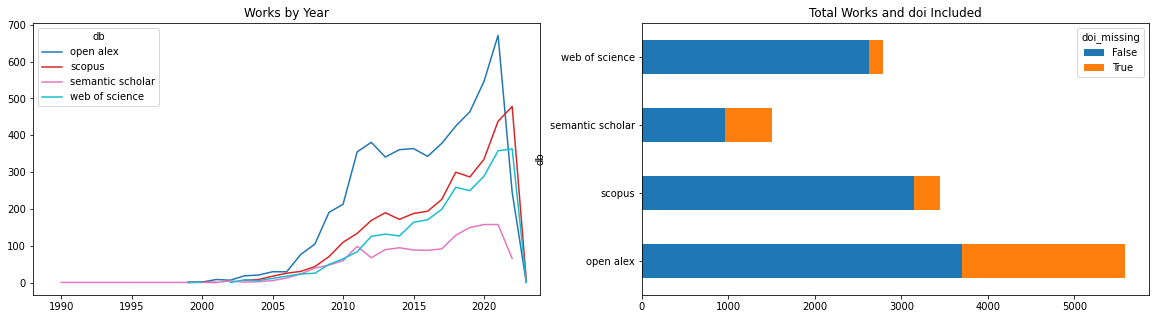

In [3]:
# Base Stats #

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

df_all.groupby(["db","year"]).size().reset_index(name="works")\
    .pivot(index="year",columns="db",values="works")\
    .plot(xlim=(1988,2024), ax=axes[0], title="Works by Year", colormap="tab10", xlabel="")

df_all.groupby(["db","doi_missing"]).size().reset_index(name="works")\
    .pivot(index="db",columns="doi_missing",values="works")\
    .plot(kind="barh", stacked=True, ax=axes[1], title="Total Works and doi Included")

plt.savefig("../local/gitlab12_basestats.png", bbox_inches="tight")

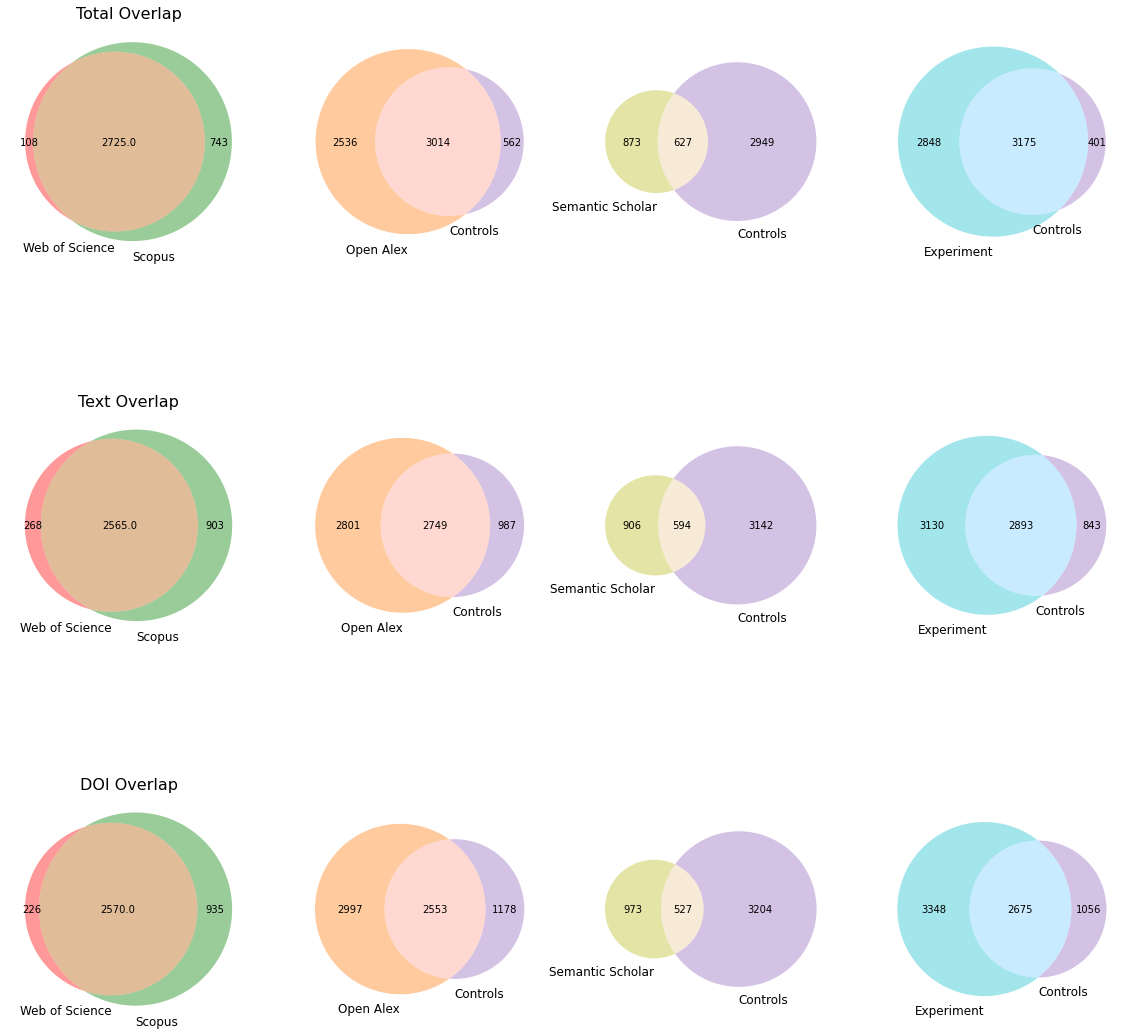

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,20))

oa_colors = ("tab:orange","tab:purple")
s2_colors = ("tab:olive","tab:purple")
exp_colors = ("tab:cyan","tab:purple")

# Total Overlap Derived From Control Table, manual calc used to remove duplicates #
# df_control.groupby(["loc_doi","loc_title"], dropna=False)[["id"]].nunique()

overlap = 2410 + (160 + 160)/2 + (79 + 5)/2 + 113
ws_only = 48 + 60
sp_only = 495 + 248
total = overlap + ws_only + sp_only

oa_results = df_oa.groupby([~df_oa["overlap_doi"].isna() | ~df_oa["overlap_title"].isna()], dropna=False)[["id"]].nunique()
s2_results = df_s2.groupby([~df_s2["overlap_doi"].isna() | ~df_s2["overlap_title"].isna()], dropna=False)[["id"]].nunique()
exp_results = df_exp.groupby([~df_exp["overlap_doi"].isna() | ~df_exp["overlap_title"].isna()], dropna=False)[["id"]].nunique()

venn2(subsets = (ws_only,sp_only,overlap),set_labels=('Web of Science', 'Scopus', ''), ax=axes[0,0])
venn2(subsets = (oa_results.loc[False][0],(total - oa_results.loc[True][0]).astype(int), oa_results.loc[True][0]), set_labels=("Open Alex", "Controls", ""), set_colors=oa_colors, ax=axes[0,1])
venn2(subsets = (s2_results.loc[False][0],(total - s2_results.loc[True][0]).astype(int), s2_results.loc[True][0]), set_labels=("Semantic Scholar", "Controls", ""), set_colors=s2_colors, ax=axes[0,2])
venn2(subsets = (exp_results.loc[False][0],(total - exp_results.loc[True][0]).astype(int), exp_results.loc[True][0]), set_labels=("Experiment", "Controls", ""), set_colors=exp_colors, ax=axes[0,3])

axes[0,0].set_title("Total Overlap", fontsize=16)

# Title Overlap Derived From Control Table #

overlap = 2410 + (79 + 5)/2 + 113
ws_only = 160 + 48 + 60
sp_only = 160 + 495 + 248
total = overlap + ws_only + sp_only

oa_results = df_oa.groupby([~df_oa["overlap_title"].isna()], dropna=False)[["id"]].nunique()
s2_results = df_s2.groupby([~df_s2["overlap_title"].isna()], dropna=False)[["id"]].nunique()
exp_results = df_exp.groupby([~df_exp["overlap_title"].isna()], dropna=False)[["id"]].nunique()

venn2(subsets = (ws_only,sp_only,overlap),set_labels=('Web of Science', 'Scopus', ''), ax=axes[1,0])
venn2(subsets = (oa_results.loc[False][0],(total - oa_results.loc[True][0]).astype(int), oa_results.loc[True][0]), set_labels=("Open Alex", "Controls", ""), set_colors=oa_colors, ax=axes[1,1])
venn2(subsets = (s2_results.loc[False][0],(total - s2_results.loc[True][0]).astype(int), s2_results.loc[True][0]), set_labels=("Semantic Scholar", "Controls", ""), set_colors=s2_colors, ax=axes[1,2])
venn2(subsets = (exp_results.loc[False][0],(total - exp_results.loc[True][0]).astype(int), exp_results.loc[True][0]), set_labels=("Experiment", "Controls", ""), set_colors=exp_colors, ax=axes[1,3])

axes[1,0].set_title("Text Overlap", fontsize=16)

# DOI Overlap Derived From Control Table #

overlap = 2410 + (160 + 160)/2
ws_only = 5 + 48 + 113 + 60
sp_only = 79 + 495 + 113 + 248
total = overlap + ws_only + sp_only

oa_results = df_oa.groupby([~df_oa["overlap_doi"].isna()], dropna=False)[["id"]].nunique()
s2_results = df_s2.groupby([~df_s2["overlap_doi"].isna()], dropna=False)[["id"]].nunique()
exp_results = df_exp.groupby([~df_exp["overlap_doi"].isna()], dropna=False)[["id"]].nunique()

venn2(subsets = (ws_only,sp_only,overlap),set_labels=('Web of Science', 'Scopus', ''), ax=axes[2,0])
venn2(subsets = (oa_results.loc[False][0],(total - oa_results.loc[True][0]).astype(int), oa_results.loc[True][0]), set_labels=("Open Alex", "Controls", ""), set_colors=oa_colors, ax=axes[2,1])
venn2(subsets = (s2_results.loc[False][0],(total - s2_results.loc[True][0]).astype(int), s2_results.loc[True][0]), set_labels=("Semantic Scholar", "Controls", ""), set_colors=s2_colors, ax=axes[2,2])
venn2(subsets = (exp_results.loc[False][0],(total - exp_results.loc[True][0]).astype(int), exp_results.loc[True][0]), set_labels=("Experiment", "Controls", ""), set_colors=exp_colors, ax=axes[2,3])

axes[2,0].set_title("DOI Overlap", fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig("../local/gitlab12_comparison.png", bbox_inches="tight")